In this notebook, I'll be playing with the Kaggle dataset 2015 flight delays and cancellations (https://www.kaggle.com/usdot/flight-delays). The goal of our project is to create a model that accurately predicts whether a flyer will experience a 'significant' delay of 30 minutes or greater. The purpose of this is to provide information to flight passengers so that the can make decisions on whether or not a flight will align with their travel goals. If they are trying to make a connecting flight or are arriving for a same-day event, a delay warning may allow them to make a better decision about which flight to take. Here is some of my experimentation with the dataset

<b>The code cells below are often reliant on the code cells above it, so make sure to run the cells sequentially<b>

In [2]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import math
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("flights.csv", low_memory=False)
print(data.shape)

(5819079, 31)


In [4]:
data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Now that we've imported the dataset, we want to drop rows that won't be important to our model. The first columns I want to drop are cancellation reason and all the delay reason columns. I don't want to drop the 'cancelled' column because I may have further use for it. 
<br><br>
Next, I want to drop all of the columns related to information we won't have before a ticket could be purchased (not including the columns we may use for a target variable). 
<br><br>
Finally, I want to drop the FLIGHT_NUMBER and TAIL_NUMBER variables as they are categorical variables with a LOT of categories and I don't think they're going to have much of an impact on our model.

In [5]:
colsToDrop0 = ['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
                      'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
colsToDrop1 = ['DEPARTURE_DELAY', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME']
colsToDrop2 = ['FLIGHT_NUMBER', 'TAIL_NUMBER']
data.drop(colsToDrop0, axis=1, inplace=True)
data.drop(colsToDrop1, axis=1, inplace=True)
data.drop(colsToDrop2, axis=1, inplace=True)
data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,2015,1,1,4,AS,ANC,SEA,5,205.0,1448,430,-22.0,0,0
1,2015,1,1,4,AA,LAX,PBI,10,280.0,2330,750,-9.0,0,0
2,2015,1,1,4,US,SFO,CLT,20,286.0,2296,806,5.0,0,0
3,2015,1,1,4,AA,LAX,MIA,20,285.0,2342,805,-9.0,0,0
4,2015,1,1,4,AS,SEA,ANC,25,235.0,1448,320,-21.0,0,0


One big issue we saw early on is that the month and all of the data is from the year 2015 and the month and the day features could be converted into a single, better feature called DAY_OF_YEAR and dropped YEAR:

In [6]:
monthToDaysDict = {1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 7: 181, 8: 212, 
                   9: 243, 10: 273, 11: 304, 12: 334}
def monthToDays(month):
    return monthToDaysDict[month]

# Convert MONTH -> # of days before a month
data['MONTH'] = data['MONTH'].apply(monthToDays)

# Convert MONTH + DAYS -> DAY_OF_YEAR
data['DAY'] = data['DAY'] + data['MONTH']
data.rename(columns={'DAY': 'DAY_OF_YEAR'}, inplace=True)
data.drop("MONTH", axis=1, inplace=True)
data.drop("YEAR", axis=1, inplace=True)
data.head()

,DAY_OF_YEAR,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,1,4,AS,ANC,SEA,5,205.0,1448,430,-22.0,0,0
1,1,4,AA,LAX,PBI,10,280.0,2330,750,-9.0,0,0
2,1,4,US,SFO,CLT,20,286.0,2296,806,5.0,0,0
3,1,4,AA,LAX,MIA,20,285.0,2342,805,-9.0,0,0
4,1,4,AS,SEA,ANC,25,235.0,1448,320,-21.0,0,0


If you look at the SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL features in the table in the cell above, they are currently in a from that looks like an integer. They represent the time as a single integer in the form of "hhmm". Drawing from Aaron's work, we decided to convert both of these features to a numeric quantity representing the number of minutes in a day (0 to 1439):

In [7]:
def hhmmFloatToMinutes(time):
    timeString = "{:04d}".format(time)
    hours = float(timeString[0:2])
    minutes = float(timeString[2:4])
    totalMinutes = (hours * 60) + minutes
    return totalMinutes

data['SCHEDULED_DEPARTURE'] = data['SCHEDULED_DEPARTURE'].apply(hhmmFloatToMinutes)
data['SCHEDULED_ARRIVAL'] = data['SCHEDULED_ARRIVAL'].apply(hhmmFloatToMinutes)
data.head()

,DAY_OF_YEAR,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,1,4,AS,ANC,SEA,5.0,205.0,1448,270.0,-22.0,0,0
1,1,4,AA,LAX,PBI,10.0,280.0,2330,470.0,-9.0,0,0
2,1,4,US,SFO,CLT,20.0,286.0,2296,486.0,5.0,0,0
3,1,4,AA,LAX,MIA,20.0,285.0,2342,485.0,-9.0,0,0
4,1,4,AS,SEA,ANC,25.0,235.0,1448,200.0,-21.0,0,0


Again, drawing from Aaron's work:
<br><br>
**There's an issue with the ORIGIN_AIRPORT and DESTINATION_AIRPORT features for October 2015. The problem is described in [this](https://www.kaggle.com/usdot/flight-delays/discussion/29600#latest-168452) post on Kaggle. The approach to fix it is drawn from [this](https://www.kaggle.com/srcole/fix-inconsistent-airport-codes) Kaggle kernel.** 

In [8]:
df_threeLetterCode = pd.read_csv('L_AIRPORT.csv')
df_fiveLetterCode = pd.read_csv('L_AIRPORT_ID.csv')

codesToDrop = ['BSM', 'NYL']
df_threeLetterCode = df_threeLetterCode[~df_threeLetterCode['Code'].isin(codesToDrop)]
threeLetterCodes = list(df_threeLetterCode['Code'])

df3 = df_threeLetterCode.set_index('Description')
df5 = df_fiveLetterCode.set_index('Code')

df_airports = data[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
df_October = df_airports.loc[~df_airports['ORIGIN_AIRPORT'].isin(threeLetterCodes) |
                            ~df_airports['DESTINATION_AIRPORT'].isin(threeLetterCodes)]

def fixOctoberAirports(airport):
    if len(airport) != 3:
        index = int(airport)
        descriptionAsKey = df5.loc[index]['Description']
        newCode = df3.loc[descriptionAsKey]['Code']
        return newCode
    else:
        return airport
    
print("Fixing origin airports:")    
fixed_origin_airport = data['ORIGIN_AIRPORT'].apply(fixOctoberAirports)

nFlights = 0
print("Fixing destination airports:")
fixed_dest_airport = data['DESTINATION_AIRPORT'].apply(fixOctoberAirports)

data['ORIGIN_AIRPORT'] = fixed_origin_airport
data['DESTINATION_AIRPORT'] = fixed_dest_airport

print()
print("Now let's test that the airports are in fact fixed:")

countTest = 0
nFlightsTest = 0
def testFixAirports(airport):
    global countTest
    global nFlightsTest
    nFlightsTest += 1
    if len(airport) != 3:
        countTest += 1
        
print("Testing ORIGIN_AIRPORT:")
countTest = 0
nFlightsTest = 0
data['ORIGIN_AIRPORT'].apply(testFixAirports)
print("countTest:", countTest)

print("Testing DESTINATION_AIRPORT:")
countTest = 0
nFlightsTest = 0
data['DESTINATION_AIRPORT'].apply(testFixAirports)
print("countTest:", countTest)

Fixing origin airports:
1000000
2000000
3000000
4000000
5000000
Fixing destination airports:
1000000
2000000
3000000
4000000
5000000

Now let's test that the airports are in fact fixed:
Testing ORIGIN_AIRPORT:
countTest: 0
Testing DESTINATION_AIRPORT:
countTest: 0


I also want to check if there are any null values in the remaining columns:

In [9]:
missing_values = data.isnull().sum(axis=0)
missing_values

DAY_OF_YEAR                 0
DAY_OF_WEEK                 0
AIRLINE                     0
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
SCHEDULED_TIME              6
DISTANCE                    0
SCHEDULED_ARRIVAL           0
ARRIVAL_DELAY          105071
DIVERTED                    0
CANCELLED                   0
dtype: int64

In [10]:
data['CANCELLED'].value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

In [11]:
data['DIVERTED'].value_counts()

0    5803892
1      15187
Name: DIVERTED, dtype: int64

In [12]:
#Find num diverted or cancelled
print("Total number of flights diverted or cancelled: ", (89884 + 15187))

Total number of flights diverted or cancelled:  105071


As you can see in the cells above, the number of missing values in the ARRIVAL_DELAY column directly matches the number of flights diverted/cancelled. There are no other missing values, so we'll proceed with our analysis.
<br><br>
I am finally ready to create the target variable for the dataset. The target variable will have to meet <b>one</b> of <b>three</b> criteria: the arrival delay must be greater than or equal to thirty minutes, the flight must be diverted, or the flight must be cancelled.

In [13]:
#Expected number of flights in class 1:
len(data[(data['ARRIVAL_DELAY'] >= 30) | (data['DIVERTED'] == 1) | (data['CANCELLED'] == 1)])

755675

In [14]:
def toSignificantDelay(delay, threshold):
    if delay >= threshold:
        return 1
    else:
        return 0
    
data['ARRIVAL_DELAY'].fillna(0) #Only rows with NA are diverted or cancelled, so this is okay
data['ARRIVAL_DELAY'] = data['ARRIVAL_DELAY'].apply(toSignificantDelay, threshold = 30)
data['SIGNIFICANT_DELAY'] = data['ARRIVAL_DELAY'] | data['DIVERTED'] | data['CANCELLED']
data['SIGNIFICANT_DELAY'].value_counts()

0    5063404
1     755675
Name: SIGNIFICANT_DELAY, dtype: int64

They match! Now we can drop the other three columns as we won't be using them:

In [15]:
colsToDrop3 = ['ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED']
data.drop(colsToDrop3, axis=1, inplace=True)
data.head()

,DAY_OF_YEAR,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,SIGNIFICANT_DELAY
0,1,4,AS,ANC,SEA,5.0,205.0,1448,270.0,0
1,1,4,AA,LAX,PBI,10.0,280.0,2330,470.0,0
2,1,4,US,SFO,CLT,20.0,286.0,2296,486.0,0
3,1,4,AA,LAX,MIA,20.0,285.0,2342,485.0,0
4,1,4,AS,SEA,ANC,25.0,235.0,1448,200.0,0


Now I would like to visualize some of the relationships between our features and our target variable. Here are some plots and charts that provide some insight:

In [16]:
import matplotlib.pyplot as plt

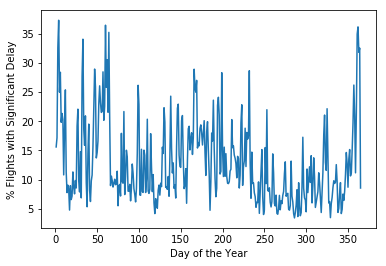

In [17]:
#Day of the year
x = []
y = []
for i in range(1, 366):
    dataDay = data.loc[data['DAY_OF_YEAR'] == i]
    x.append(i)
    y.append(dataDay['SIGNIFICANT_DELAY'].mean() * 100)
             
plt.plot(x, y)
plt.xlabel("Day of the Year")
plt.ylabel("% Flights with Significant Delay")
plt.show()

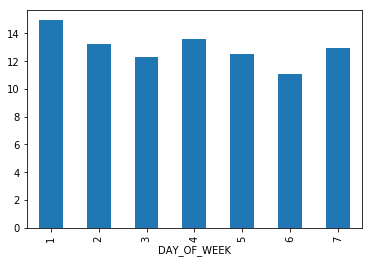

In [18]:
grouped = data.groupby(['DAY_OF_WEEK'])['SIGNIFICANT_DELAY']
(grouped.mean() * 100).plot(kind='bar')
plt.show()
#1 = Monday, 7 = Sunday

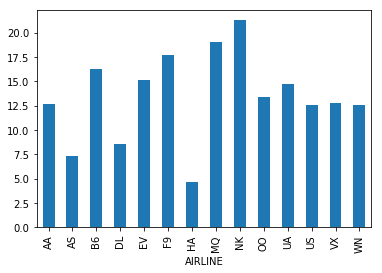

In [19]:
grouped = data.groupby(['AIRLINE'])['SIGNIFICANT_DELAY']
(grouped.mean() * 100).plot(kind='bar')
plt.show()

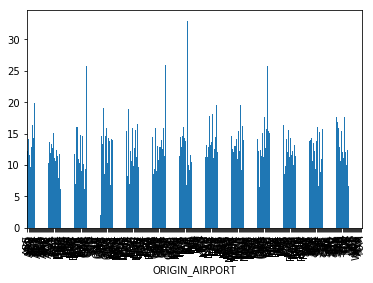

In [20]:
grouped = data.groupby(['ORIGIN_AIRPORT'])['SIGNIFICANT_DELAY']
(grouped.mean() * 100).plot(kind='bar')
plt.show()

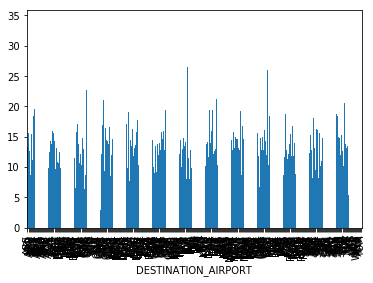

In [21]:
grouped = data.groupby(['DESTINATION_AIRPORT'])['SIGNIFICANT_DELAY']
(grouped.mean() * 100).plot(kind='bar')
plt.show()

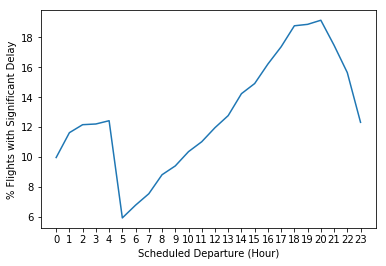

In [22]:
#Scheduled Departure
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
y = []
for i in x:
    mask = (data['SCHEDULED_DEPARTURE'] >= i * 60) & (data['SCHEDULED_DEPARTURE'] < (i + 1) * 60)
    dataHour = data.loc[mask]
    y.append(dataHour['SIGNIFICANT_DELAY'].mean() * 100)
             
plt.plot(x, y)
plt.xticks(range(0, 24), x)
plt.xlabel("Scheduled Departure (Hour)")
plt.ylabel("% Flights with Significant Delay")
plt.show()

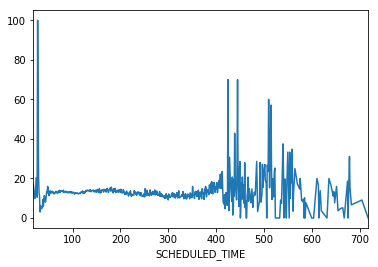

In [67]:
#Day of the year
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
y = []
for i in x:
    mask = (data['SCHEDULED_DEPARTURE'] >= i * 60) & (data['SCHEDULED_DEPARTURE'] <= (i + 1) * 60)
    dataHour = data.loc[mask]
    y.append(dataHour['SIGNIFICANT_DELAY'].mean() * 100)
             
plt.plot(x, y)
plt.xticks(range(0, 24), x)
plt.xlabel("Scheduled Departure (Hour)")
plt.ylabel("% Flights with Significant Delay")
plt.show()

In [ ]:
#Do scheduled time here

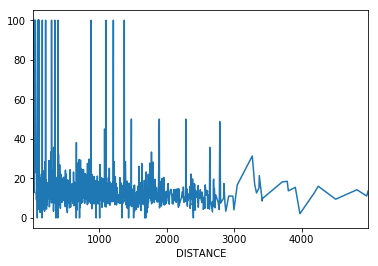

In [68]:
grouped = data.groupby(['DISTANCE'])['SIGNIFICANT_DELAY']
(grouped.mean() * 100).plot()
plt.show()

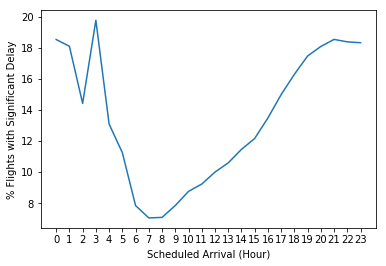

In [23]:
#Scheduled Arrival
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
y = []
for i in x:
    mask = (data['SCHEDULED_ARRIVAL'] >= i * 60) & (data['SCHEDULED_ARRIVAL'] <= (i + 1) * 60)
    dataHour = data.loc[mask]
    y.append(dataHour['SIGNIFICANT_DELAY'].mean() * 100)
             
plt.plot(x, y)
plt.xticks(range(0, 24), x)
plt.xlabel("Scheduled Arrival (Hour)")
plt.ylabel("% Flights with Significant Delay")
plt.show()

Now, using the data that we have, I would like to try creating a simple Random Forest Model:

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [30]:
missing_values = data.isnull().sum(axis=0)
missing_values

DAY_OF_YEAR            0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
SCHEDULED_TIME         6
DISTANCE               0
SCHEDULED_ARRIVAL      0
SIGNIFICANT_DELAY      0
dtype: int64

In [35]:
data2 = data.dropna()
X = data2[['DAY_OF_YEAR', 'DAY_OF_WEEK', \
         'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL']]
y = data2['SIGNIFICANT_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
paramRF = {'n_estimators':[10], 'max_depth':[None], 'max_features':[1]}
RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=paramRF, scoring='accuracy', verbose=1)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.7min finished


0.853328264668
[[1612575   58709]
 [ 222944   26067]]


In [37]:
data2 = data.dropna()
data2 = data2.sample(frac=0.1, replace=False)
# TODO: Double check whether the index should be reset
data2 = data2.reset_index()
data2 = data2.drop(['index'], axis=1)
X = data2[['DAY_OF_YEAR', 'DAY_OF_WEEK', \
         'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL']]
y = data2['SIGNIFICANT_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
paramRF = {'n_estimators':[10], 'max_depth':[None], 'max_features':[1]}
RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=paramRF, scoring='accuracy', verbose=1)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.3s finished


0.861177940947
[[164042   3172]
 [ 23486   1330]]


In [39]:
RF_classifier.best_estimator_.feature_importances_

array([ 0.21175803,  0.03737346,  0.18481407,  0.17037216,  0.19741483,
        0.19826746])

In [40]:
data2 = data.dropna()
data2 = data2.sample(frac=0.1, replace=False)
# TODO: Double check whether the index should be reset
data2 = data2.reset_index()
data2 = data2.drop(['index'], axis=1)
X = data2[['DAY_OF_YEAR', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL']]
y = data2['SIGNIFICANT_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
paramRF = {'n_estimators':[10], 'max_depth':[None], 'max_features':[1]}
RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=paramRF, scoring='accuracy', verbose=1)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(RF_classifier.best_estimator_.feature_importances_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.8s finished


0.845836588033
[[160076   7062]
 [ 22542   2350]]
[ 0.39332738  0.1499594   0.13512698  0.1615226   0.16006364]


In [44]:
def getSine(doy):
    return math.sin(2 * math.pi * (doy / 366))

def getCosine(doy):
    return math.cos(2 * math.pi * (doy / 366))

data = data.dropna()
dataT = data.sample(frac=0.1, replace=False)
dataT['DOY_X'] = data['DAY_OF_YEAR'].apply(getCosine)
dataT['DOY_Y'] = data['DAY_OF_YEAR'].apply(getSine)
dataT.drop(["DAY_OF_YEAR"], 1, inplace=True)

In [45]:
dataT.head()

,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,SIGNIFICANT_DELAY,DOY_X,DOY_Y
201958,3,WN,PHX,LAS,440.0,70.0,255,450.0,0,0.971257,0.238033
4261773,3,WN,DAL,MAF,455.0,70.0,319,525.0,0,-0.145404,-0.989372
440333,4,WN,BNA,CMH,1195.0,70.0,337,1325.0,1,0.878612,0.477536
3950716,3,NK,MSP,DFW,1130.0,137.0,852,1267.0,0,-0.485060,-0.874481
154623,7,OO,EUG,SLC,360.0,115.0,618,535.0,0,0.982223,0.187719


In [47]:
X = dataT[['DOY_X', 'DOY_Y', 'DAY_OF_WEEK', \
         'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL']]
y = dataT['SIGNIFICANT_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
paramRF = {'n_estimators':[10], 'max_depth':[None], 'max_features':[1]}
RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=paramRF, scoring='accuracy', verbose=1)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(RF_classifier.best_estimator_.feature_importances_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.2s finished


0.861818465865
[[164036   2796]
 [ 23739   1459]]
[ 0.09741508  0.09416702  0.02721971  0.19206679  0.1815025   0.20358223
  0.20404668]


In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
logReg = LogisticRegression(penalty='l2', C=1000000)
logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.868780919648
[[166832      0]
 [ 25198      0]]


In [50]:
dataT = data
dataT = pd.get_dummies(dataT, columns=['DAY_OF_WEEK', 'AIRLINE'], 
                                     drop_first=True)

In [56]:
def runRF(X, y, params):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
    RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='accuracy', verbose=1)
    RF_classifier.fit(X_train, y_train)
    y_pred = RF_classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(RF_classifier.best_estimator_.feature_importances_)

In [57]:
paramRF = {'n_estimators':[10], 'max_depth':[None], 'max_features':[1]}
X = dataT
X = X.sample(frac=0.1, replace=False)
y = X['SIGNIFICANT_DELAY']
X = X.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SIGNIFICANT_DELAY'], axis = 1)
runRF(X, y, paramRF)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.4s finished


0.857303546321
[[162794   4195]
 [ 23207   1834]]
[ 0.2438431   0.18434407  0.16344035  0.17452349  0.19577085  0.002593
  0.0028231   0.00325633  0.00213187  0.00239722  0.00314852  0.00133553
  0.00161226  0.00415136  0.00160871  0.00088109  0.00063732  0.00265317
  0.00197313  0.00171804  0.00159933  0.00073621  0.00055227  0.0022697 ]


In [59]:
print() 
print() 
print() 
print() 
print()

In [62]:
dataT = data.sample(frac=0.1, replace=False)
def getSine(doy, total):
    return math.sin(2 * math.pi * (doy / total))

def getCosine(doy, total):
    return math.cos(2 * math.pi * (doy / total))

data = data.dropna()
dataT = data.sample(frac=0.1, replace=False)
dataT['DOY_X'] = data['DAY_OF_YEAR'].apply(getCosine, total=365)
dataT['DOY_Y'] = data['DAY_OF_YEAR'].apply(getSine, total=365)
dataT['DOW_X'] = data['DAY_OF_WEEK'].apply(getCosine, total=7)
dataT['DOW_Y'] = data['DAY_OF_WEEK'].apply(getSine, total=7)
dataT['SD_X'] = data['SCHEDULED_DEPARTURE'].apply(getCosine, total=1440)
dataT['SD_Y'] = data['SCHEDULED_DEPARTURE'].apply(getSine, total=1440)
dataT['SA_X'] = data['SCHEDULED_ARRIVAL'].apply(getCosine, total=1440)
dataT['SA_Y'] = data['SCHEDULED_ARRIVAL'].apply(getSine, total=1440)
dataT.drop(['DAY_OF_YEAR', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], 1, inplace=True)
dataT.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,SIGNIFICANT_DELAY,DOY_X,DOY_Y,DOW_X,DOW_Y,SD_X,SD_Y,SA_X,SA_Y
5339482,WN,DEN,OAK,165.0,957,0,0.860961,-0.508671,0.623490,0.781831,9.063078e-01,-0.422618,0.999762,0.021815
2240150,UA,HNL,IAD,561.0,4817,0,-0.766659,0.642055,-0.222521,-0.974928,-5.372996e-01,-0.843391,-0.304864,0.952396
542744,DL,LGA,MSP,206.0,1020,0,0.814046,0.580800,-0.900969,-0.433884,-1.836970e-16,-1.000000,0.594823,-0.803857
1917316,DL,JFK,SAN,374.0,2446,0,-0.504961,0.863142,0.623490,-0.781831,3.007058e-01,-0.953717,0.913545,-0.406737
5331543,MQ,ORD,COU,87.0,315,0,0.860961,-0.508671,0.623490,0.781831,-9.044551e-01,-0.426569,-0.681998,-0.731354


In [72]:
X = dataT.drop(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SIGNIFICANT_DELAY'], axis = 1)
y = dataT['SIGNIFICANT_DELAY']

In [73]:
paramRF = {'n_estimators':[10], 'max_depth':[None], 'max_features':[1]}
runRF(X, y, paramRF)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.2s finished


0.862714159246
[[164420   2684]
 [ 23679   1247]]
[ 0.13320328  0.14521843  0.10462699  0.1034149   0.00638928  0.01181017
  0.11548443  0.12063274  0.13009966  0.12912013]


In [74]:
paramRF = {'n_estimators':[50], 'max_depth':[None], 'max_features':[1]}
runRF(X, y, paramRF)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished


0.866125084622
[[165305   1799]
 [ 23909   1017]]
[ 0.13282075  0.14467759  0.10305019  0.10313845  0.00740026  0.01431419
  0.11661139  0.11861394  0.13062631  0.12874694]


In [75]:
paramRF = {'n_estimators':[10], 'max_depth':[None]}
runRF(X, y, paramRF)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.0s finished


0.860740509295
[[163683   3421]
 [ 23321   1605]]
[ 0.13687459  0.15390627  0.08760733  0.08995931  0.02389266  0.03479616
  0.10781943  0.11405323  0.12664029  0.12445073]


In [76]:
paramRF = {'n_estimators':[10], 'max_depth':[None], 'max_features':[None]}
runRF(X, y, paramRF)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


0.858647086393
[[162886   4218]
 [ 22926   2000]]
[ 0.15879598  0.19774668  0.06698122  0.0643738   0.02159027  0.03396633
  0.10211564  0.11573667  0.11925526  0.11943816]


In [77]:
def average_per_class_acc(conf_mat):
    per_class_accuracies = []
    for i in range(len(conf_mat)):
        class_predictions = conf_mat[i]
        samples_in_class = np.sum(class_predictions)
        num_predictions = conf_mat[i, i]
        class_accuracy = num_predictions / float(samples_in_class)
        per_class_accuracies.append(class_accuracy)
    per_class_accuracies = np.array(per_class_accuracies)
    average_per_class_acc = per_class_accuracies.mean()
    return average_per_class_acc

In [80]:
def runRF(X, y, params):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
    RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='f1_score', verbose=1)
    RF_classifier.fit(X_train, y_train)
    y_pred = RF_classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(RF_classifier.best_estimator_.feature_importances_)
    print(average_per_class_acc(confusion_matrix(y_test, y_pred)))

In [81]:
paramRF = {'n_estimators':[15], 'max_depth':[None], 'max_features':[None]}
runRF(X, y, paramRF)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished


0.85701192522
[[162140   4964]
 [ 22494   2432]]
[ 0.15988343  0.19725881  0.06652482  0.06553801  0.02220366  0.03315546
  0.10274849  0.1145323   0.11978352  0.1183715 ]
0.533931376169


In [82]:
from sklearn.metrics import f1_score

In [83]:
def runRF(X, y, params):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
    RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='f1', verbose=1)
    RF_classifier.fit(X_train, y_train)
    y_pred = RF_classifier.predict(X_test)
    print(RF_classifier.best_score_)
    print(confusion_matrix(y_test, y_pred))
    print(RF_classifier.best_estimator_.feature_importances_)
    print(average_per_class_acc(confusion_matrix(y_test, y_pred)))
    print(f1_score(y_test, y_pred))

In [85]:
paramRF = {'n_estimators':[10], 'max_depth':[None]}
runRF(X, y, paramRF)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished


0.121667665326
[[162909   4195]
 [ 22907   2019]]
[ 0.1597211   0.19816275  0.06662955  0.06527668  0.02153381  0.03397521
  0.10314552  0.11534373  0.1190446   0.11716704]
0.527947816258
0.129672447013


In [86]:
data['AIRLINE'].value_counts()

WN    1261855
DL     875881
AA     725984
OO     588353
EV     571977
UA     515723
MQ     294632
B6     267048
US     198715
AS     172521
NK     117373
F9      90836
HA      76272
VX      61903
Name: AIRLINE, dtype: int64

In [93]:
airlines = ['WN', 'DL', 'AA', 'OO', 'EV', 'UA', 'MQ', 'B6', 'US', 'AS', 'NK', 'F9', 'HA', 'VX']

def airlineEnsemble(data, params):
    Y_test = []
    Y_pred = []
    for a in airlines:
        dataT = data.loc[data['AIRLINE'] == a]
        X = dataT[['DAY_OF_YEAR', 'DAY_OF_WEEK', \
         'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL']]
        y = dataT['SIGNIFICANT_DELAY']
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
        RF_classifier = GridSearchCV(XGBClassifier(), param_grid=params, scoring='f1', verbose=0)
        RF_classifier.fit(X_train, y_train)
        y_pred = RF_classifier.predict(X_test)
        for y in y_test:
            Y_test.append(y)
        for y in y_pred:
            Y_pred.append(y)
    print(confusion_matrix(Y_test, Y_pred))
    print(average_per_class_acc(confusion_matrix(Y_test, Y_pred)))
    print(f1_score(Y_test, Y_pred))

In [94]:
dataF = data.sample(frac=0.1, replace=False)
paramRF = {'n_estimators':[10], 'max_depth':[12]}
airlineEnsemble(dataF, paramRF)

[[164491   2509]
 [ 22824   2214]]
0.536700820501
0.148785323074


In [92]:
from xgboost.sklearn import XGBClassifier

In [96]:
dataT = data.sample(frac=0.1, replace=False)
def getSine(doy, total):
    return math.sin(2 * math.pi * (doy / total))

def getCosine(doy, total):
    return math.cos(2 * math.pi * (doy / total))

data = data.dropna()
dataT = data.sample(frac=0.1, replace=False)
dataT['DOY_X'] = data['DAY_OF_YEAR'].apply(getCosine, total=365)
dataT['DOY_Y'] = data['DAY_OF_YEAR'].apply(getSine, total=365)
dataT['DOW_X'] = data['DAY_OF_WEEK'].apply(getCosine, total=7)
dataT['DOW_Y'] = data['DAY_OF_WEEK'].apply(getSine, total=7)
dataT['SD_X'] = data['SCHEDULED_DEPARTURE'].apply(getCosine, total=1440)
dataT['SD_Y'] = data['SCHEDULED_DEPARTURE'].apply(getSine, total=1440)
dataT['SA_X'] = data['SCHEDULED_ARRIVAL'].apply(getCosine, total=1440)
dataT['SA_Y'] = data['SCHEDULED_ARRIVAL'].apply(getSine, total=1440)
dataT.drop(['DAY_OF_YEAR', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], 1, inplace=True)

In [103]:
'DAY_OF_YEAR', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'
airlines = ['WN', 'DL', 'AA', 'OO', 'EV', 'UA', 'MQ', 'B6', 'US', 'AS', 'NK', 'F9', 'HA', 'VX']

def airlineEnsemble(data, params):
    Y_test = []
    Y_pred = []
    for a in airlines:
        dataT = data.loc[data['AIRLINE'] == a]
        X = dataT[['DOY_X', 'DOY_Y', 'DOW_X', 'DOW_Y', 'SD_X', 'SD_Y', 'SA_X', 'SA_Y', \
         'SCHEDULED_TIME', 'DISTANCE']]
        y = dataT['SIGNIFICANT_DELAY']
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
        RF_classifier = GridSearchCV(XGBClassifier(), param_grid=params, scoring='f1', verbose=0)
        RF_classifier.fit(X_train, y_train)
        y_pred = RF_classifier.predict(X_test)
        for y in y_test:
            Y_test.append(y)
        for y in y_pred:
            Y_pred.append(y)
    print(confusion_matrix(Y_test, Y_pred))
    print(average_per_class_acc(confusion_matrix(Y_test, Y_pred)))
    print(f1_score(Y_test, Y_pred))

In [105]:
params = [{'n_estimators':[50], 'max_depth':[12]}, \
             {'n_estimators':[50], 'max_depth':[6]}, \
             {'n_estimators':[10], 'max_depth':[12]}, \
             {'n_estimators':[10], 'max_depth':[6]}]
airlineEnsemble(dataT, params)

[[164947   2274]
 [ 22594   2218]]
0.537896729538
0.151378651379


In [106]:
def airlineEnsembleRF(data, params):
    Y_test = []
    Y_pred = []
    for a in airlines:
        dataT = data.loc[data['AIRLINE'] == a]
        X = dataT[['DOY_X', 'DOY_Y', 'DOW_X', 'DOW_Y', 'SD_X', 'SD_Y', 'SA_X', 'SA_Y', \
         'SCHEDULED_TIME', 'DISTANCE']]
        y = dataT['SIGNIFICANT_DELAY']
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
        RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='f1', verbose=0)
        RF_classifier.fit(X_train, y_train)
        y_pred = RF_classifier.predict(X_test)
        for y in y_test:
            Y_test.append(y)
        for y in y_pred:
            Y_pred.append(y)
    print(confusion_matrix(Y_test, Y_pred))
    print(average_per_class_acc(confusion_matrix(Y_test, Y_pred)))
    print(f1_score(Y_test, Y_pred))

In [107]:
params = [{'n_estimators':[50], 'max_depth':[None], 'max_features':[10]}, \
             {'n_estimators':[50], 'max_depth':[6], 'max_features':[10]}, \
             {'n_estimators':[10], 'max_depth':[None], 'max_features':[10]}, \
             {'n_estimators':[10], 'max_depth':[6], 'max_features':[10]}, \
             {'n_estimators':[50], 'max_depth':[None], 'max_features':[None]}, \
             {'n_estimators':[10], 'max_depth':[None], 'max_features':[None]}, \
             {'n_estimators':[50], 'max_depth':[6], 'max_features':[None]}, \
             {'n_estimators':[10], 'max_depth':[6], 'max_features':[None]}]
airlineEnsembleRF(dataT, params)

[[163026   4195]
 [ 21880   2932]]
0.546541032994
0.183599987476
